## 🕸️ GNN Model Playground
### Heterogeneous GNN Models for Drug Response Prediction and Node Embedding Generation

This notebook implements and compares two heterogeneous graph neural network approaches on DepMap cancer cell line data: (1) A HeteroGNN model with attention mechanisms for predicting IC50 drug response values via link prediction, and (2) A Heterogeneous Graph Transformer (HGT) for generating meaningful node embeddings of genes, cell lines, and drugs. Both models are trained on multi-modal biological networks and evaluated for their ability to capture drug-cell line interactions and produce interpretable embeddings for downstream analysis.

In [ ]:
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F

from src.utils.model_utils import set_seed

# Set random seed
set_seed(42)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)


/Users/ktjf809/opt/anaconda3/envs/torch-M1/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ktjf809/opt/anaconda3/envs/torch-M1/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ktjf809/opt/anaconda3/envs/torch-M1/lib/python3.8

## 1. Load Heterogeneous Graphs

Load train and test graphs created in `00_data_processing.ipynb`.

In [ ]:
# Load heterogeneous graphs
project_dir = '../'

train_hetero_graph = torch.load(project_dir + 'data/processed/depmap_hetero_graph_train_smaller.pt')
val_hetero_graph = torch.load(project_dir + 'data/processed/depmap_hetero_graph_val_smaller.pt')
test_hetero_graph = torch.load(project_dir + 'data/processed/depmap_hetero_graph_test_smaller.pt')

print(f"  Node types: {train_hetero_graph.node_types}")
print(f"  Edge types: {len(train_hetero_graph.edge_types)} types\n")

print(f" Node counts:")
for nt in train_hetero_graph.node_types:
    print(f"  {nt}: {train_hetero_graph[nt].num_nodes}")

print(f"\n Key edge types:")
for et in [('cell_line', 'expresses', 'gene'), 
           ('cell_line', 'treated_with', 'drug'),
           ('drug', 'targets', 'gene'),
           ('gene', 'interacts', 'gene')]:
    if et in train_hetero_graph.edge_types:
        print(f"  {et}: {train_hetero_graph[et].edge_index.shape[1]} edges")

  Node types: ['cell_line', 'gene', 'drug']
  Edge types: 11 types

 Node counts:
  cell_line: 463
  gene: 3919
  drug: 148

 Key edge types:
  ('cell_line', 'expresses', 'gene'): 1812182 edges
  ('cell_line', 'treated_with', 'drug'): 73076 edges
  ('drug', 'targets', 'gene'): 148 edges
  ('gene', 'interacts', 'gene'): 53080 edges


In [3]:
# inspect graph structure
train_hetero_graph

HeteroData(
  cell_line={
    x=[463, 42],
    num_nodes=463,
    node_ids=[463]
  },
  gene={
    x=[3919, 3919],
    num_nodes=3919,
    node_ids=[3919]
  },
  drug={
    x=[148, 148],
    num_nodes=148,
    node_ids=[148]
  },
  (cell_line, expresses, gene)={
    edge_index=[2, 1812182],
    edge_attr=[1812182, 1]
  },
  (cell_line, has_mutation, gene)={ edge_index=[2, 10308] },
  (cell_line, has_gene_effect, gene)={
    edge_index=[2, 1320047],
    edge_attr=[1320047, 1]
  },
  (cell_line, treated_with, drug)={
    edge_index=[2, 73076],
    edge_attr=[73076, 1]
  },
  (drug, targets, gene)={ edge_index=[2, 148] },
  (gene, interacts, gene)={ edge_index=[2, 53080] },
  (gene, expressed_by, cell_line)={
    edge_index=[2, 1812182],
    edge_attr=[1812182, 1]
  },
  (gene, mutated_in, cell_line)={ edge_index=[2, 10308] },
  (gene, has_gene_effect_in, cell_line)={ edge_index=[2, 1320047] },
  (drug, treats, cell_line)={ edge_index=[2, 73076] },
  (gene, targeted_by, drug)={ edge_index

## 2. Prepare Data for Training

In [4]:
# prepare metadata for heterogeneous models
metadata = (train_hetero_graph.node_types, train_hetero_graph.edge_types)

# get input dimensions for each node type
in_channels_dict = {
    'cell_line': train_hetero_graph['cell_line'].x.shape[1],
    'gene': train_hetero_graph['gene'].x.shape[1],
    'drug': train_hetero_graph['drug'].x.shape[1]
}

print(f"Input feature dimensions:")
for nt, dim in in_channels_dict.items():
    print(f"  {nt}: {dim}")

Input feature dimensions:
  cell_line: 42
  gene: 3919
  drug: 148


In [5]:
# prep edge attribute dictionaries

train_edge_attr_dict = {}
for edge_type in train_hetero_graph.edge_types:
    if hasattr(train_hetero_graph[edge_type], 'edge_attr'):
        train_edge_attr_dict[edge_type] = train_hetero_graph[edge_type].edge_attr

val_edge_attr_dict = {}
for edge_type in val_hetero_graph.edge_types:
    if hasattr(val_hetero_graph[edge_type], 'edge_attr'):
        val_edge_attr_dict[edge_type] = val_hetero_graph[edge_type].edge_attr


test_edge_attr_dict = {}
for edge_type in test_hetero_graph.edge_types:
    if hasattr(test_hetero_graph[edge_type], 'edge_attr'):
        test_edge_attr_dict[edge_type] = test_hetero_graph[edge_type].edge_attr

print(f"Edge types with attributes: {list(train_edge_attr_dict.keys())}")

# attach edge_attr_dict to graphs for easy access

train_hetero_graph.edge_attr_dict = train_edge_attr_dict
val_hetero_graph.edge_attr_dict = val_edge_attr_dict
test_hetero_graph.edge_attr_dict = test_edge_attr_dict

Edge types with attributes: [('cell_line', 'expresses', 'gene'), ('cell_line', 'has_gene_effect', 'gene'), ('cell_line', 'treated_with', 'drug'), ('gene', 'expressed_by', 'cell_line')]


In [6]:
train_hetero_graph

HeteroData(
  edge_attr_dict={
    (cell_line, expresses, gene)=[1812182, 1],
    (cell_line, has_gene_effect, gene)=[1320047, 1],
    (cell_line, treated_with, drug)=[73076, 1],
    (gene, expressed_by, cell_line)=[1812182, 1]
  },
  cell_line={
    x=[463, 42],
    num_nodes=463,
    node_ids=[463]
  },
  gene={
    x=[3919, 3919],
    num_nodes=3919,
    node_ids=[3919]
  },
  drug={
    x=[148, 148],
    num_nodes=148,
    node_ids=[148]
  },
  (cell_line, expresses, gene)={
    edge_index=[2, 1812182],
    edge_attr=[1812182, 1]
  },
  (cell_line, has_mutation, gene)={ edge_index=[2, 10308] },
  (cell_line, has_gene_effect, gene)={
    edge_index=[2, 1320047],
    edge_attr=[1320047, 1]
  },
  (cell_line, treated_with, drug)={
    edge_index=[2, 73076],
    edge_attr=[73076, 1]
  },
  (drug, targets, gene)={ edge_index=[2, 148] },
  (gene, interacts, gene)={ edge_index=[2, 53080] },
  (gene, expressed_by, cell_line)={
    edge_index=[2, 1812182],
    edge_attr=[1812182, 1]
  },
  

## 3. Example 1: HeteroGNN link prediction

In [ ]:
import os
os.chdir('../')

In [8]:
# Reload the modules to pick up changes
import importlib
import sys
if 'src.models' in sys.modules:
    importlib.reload(sys.modules['src.models'])
if 'src.models.hetero_gnn_models' in sys.modules:
    importlib.reload(sys.modules['src.models.hetero_gnn_models'])

In [9]:
from src.models import (
    HeteroGNNDrugPredictor, group, HeteroConv2, HeteroGATWithAttention, DrugResponseEdgeDecoder, HGTModel
)



In [10]:
# Define training and testing functions

def weighted_mse_loss_fixed(pred, target, weight=None):
    """Fixed weighted MSE loss for regression """
    if weight is not None:
        # Apply weights to each sample
        mse_loss_per_sample = (pred - target) ** 2
        if len(weight) == 2:
            # Binary weighting based on target value ranges
            high_ic50_mask = (target > target.median()).float()
            sample_weights = high_ic50_mask * weight[1] + (1 - high_ic50_mask) * weight[0]
            weighted_loss = (mse_loss_per_sample * sample_weights.unsqueeze(1)).mean()
        else:
            weighted_loss = (mse_loss_per_sample * weight.unsqueeze(1)).mean()
        return weighted_loss
    else:
        return F.mse_loss(pred, target)

def train_fixed():
    """Fixed training function using corrected loss """
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    pred = model(train_hetero_graph.x_dict, train_hetero_graph.edge_index_dict, 
                 train_hetero_graph.edge_attr_dict,
                 train_hetero_graph['cell_line', 'drug'].edge_index)
    
    target = train_hetero_graph['cell_line', 'drug'].y
    
    # Use fixed weighted loss
    loss = weighted_mse_loss_fixed(pred, target, weight)
    
    loss.backward()
    optimizer.step()
    return loss.item()

def test_fixed(data):
    """Fixed testing function with proper metrics calculation"""
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict,
                     data['cell_line', 'drug'].edge_index)
        target = data['cell_line', 'drug'].y
        
        # Calculate metrics
        mse = F.mse_loss(pred, target).item()
        rmse = np.sqrt(mse)
        mae = F.l1_loss(pred, target).item()
        
        # Additional metrics
        pred_np = pred.cpu().numpy().flatten()
        target_np = target.cpu().numpy().flatten()
        
        # Correlation
        correlation = np.corrcoef(pred_np, target_np)[0, 1]
        
        # R-squared
        ss_res = np.sum((target_np - pred_np) ** 2)
        ss_tot = np.sum((target_np - np.mean(target_np)) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
        
        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'correlation': correlation,
            'r2': r2,
            'predictions': pred_np,
            'targets': target_np
        }

In [11]:
# complete training setup

# defining loss functions again
def regular_mse_loss(pred, target):
    """Simple MSE loss for regression"""
    return F.mse_loss(pred, target.to(pred.dtype))

def robust_loss(pred, target, beta=1.0):
    """Robust Huber loss for regression (less sensitive to outliers)"""
    diff = pred - target.to(pred.dtype)
    abs_diff = torch.abs(diff)
    quadratic = torch.minimum(abs_diff, torch.tensor(beta))
    linear = abs_diff - quadratic
    return (0.5 * quadratic.pow(2) + beta * linear).mean()

# model and optimizer
print("creating model...")
model = HeteroGNNDrugPredictor(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# model initialisation
print("Initialising model...")
with torch.no_grad():
    # get edge type for drug response (IC50)
    if ('cell_line', 'treated_with', 'drug') in train_hetero_graph.edge_types:
        target_edge_type = ('cell_line', 'treated_with', 'drug')
        print(f"using edge type: {target_edge_type}")
    elif ('cell_line', 'drug') in train_hetero_graph.edge_types:
        target_edge_type = ('cell_line', 'drug')
        print(f"using edge type: {target_edge_type}")
    else:
        print("no suitable edge type found")
        print(f"Available: {train_hetero_graph.edge_types}")
        target_edge_type = None

    if target_edge_type:
        _ = model(train_hetero_graph.x_dict, train_hetero_graph.edge_index_dict, 
                  train_hetero_graph.edge_attr_dict,
                  train_hetero_graph[target_edge_type].edge_index)
        print("model initialised successfully")

# training function
def train_corrected():
    """training function with proper error handling"""
    model.train()
    optimizer.zero_grad()
    
    try:
        # Forward pass
        pred = model(train_hetero_graph.x_dict, train_hetero_graph.edge_index_dict, 
                    train_hetero_graph.edge_attr_dict,
                    train_hetero_graph[target_edge_type].edge_index)
        
        # Get target values
        target = train_hetero_graph[target_edge_type].edge_attr
        if target.dim() > 1:
            target = target.squeeze(-1)
        
        print(f"pred shape= {pred.shape}, target shape= {target.shape}")
        
        # Compute loss
        loss = regular_mse_loss(pred, target)
        
        # L2 regularization
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        return float(loss)
        
    except Exception as e:
        print(f"training step failed @ {e}")
        import traceback
        traceback.print_exc()
        return None

# test function
@torch.no_grad()
def test_corrected(data):
    """testing function with proper error handling"""
    model.eval()
    try:
        pred = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict,
                     data[target_edge_type].edge_index)
        target = data[target_edge_type].edge_attr
        if target.dim() > 1:
            target = target.squeeze(-1)
        
        # Calculate metrics
        mse = F.mse_loss(pred, target.float())
        rmse = mse.sqrt()
        mae = F.l1_loss(pred, target.float())
        
        return {
            'mse': float(mse),
            'rmse': float(rmse), 
            'mae': float(mae)
        }
    except Exception as e:
        print(f"test step failed @ {e}")
        return {'mse': float('inf'), 'rmse': float('inf'), 'mae': float('inf')}

print("training functions done")

#### test one step
if target_edge_type:
    print("\n=== Testing One Training Step ===")
    loss = train_corrected()
    if loss is not None:
        print(f"training step successful! Loss: {loss:.6f}")
        
        # test evaluation  
        metrics = test_corrected(train_hetero_graph)
        print(f"evaluation step completed")
        print(f"  RMSE: {metrics['rmse']:.6f}")
        print(f"  MAE: {metrics['mae']:.6f}")
    else:
        print("training step failed")
else:
    print("cannot proceed without valid edge type")

creating model...
Initialising model...
using edge type: ('cell_line', 'treated_with', 'drug')
model initialised successfully
training functions done

=== Testing One Training Step ===
pred shape= torch.Size([73076]), target shape= torch.Size([73076])
training step successful! Loss: 75.804359
evaluation step completed
  RMSE: 3.771540
  MAE: 2.904394


=== Starting Robust Training Loop ===
pred shape= torch.Size([73076]), target shape= torch.Size([73076])
Epoch  1: Loss=9.282362 | Train RMSE=2.7452 | Val RMSE=2.8244 | Test RMSE=1.7365
pred shape= torch.Size([73076]), target shape= torch.Size([73076])
Epoch  2: Loss=10.127681 | Train RMSE=2.7983 | Val RMSE=2.8836 | Test RMSE=1.5936
pred shape= torch.Size([73076]), target shape= torch.Size([73076])
Epoch  3: Loss=10.210051 | Train RMSE=2.7809 | Val RMSE=2.8640 | Test RMSE=1.6332
pred shape= torch.Size([73076]), target shape= torch.Size([73076])
Epoch  4: Loss=10.215351 | Train RMSE=2.7111 | Val RMSE=2.7840 | Test RMSE=1.8274
pred shape= torch.Size([73076]), target shape= torch.Size([73076])
Epoch  5: Loss=9.592583 | Train RMSE=2.6350 | Val RMSE=2.6852 | Test RMSE=2.1222
pred shape= torch.Size([73076]), target shape= torch.Size([73076])
Epoch  6: Loss=8.897207 | Train RMSE=2.5924 | Val RMSE=2.6098 | Test RMSE=2.4499
pred shape= torch.Size([73076]), target shape= torch.Size([73076])
Epoc

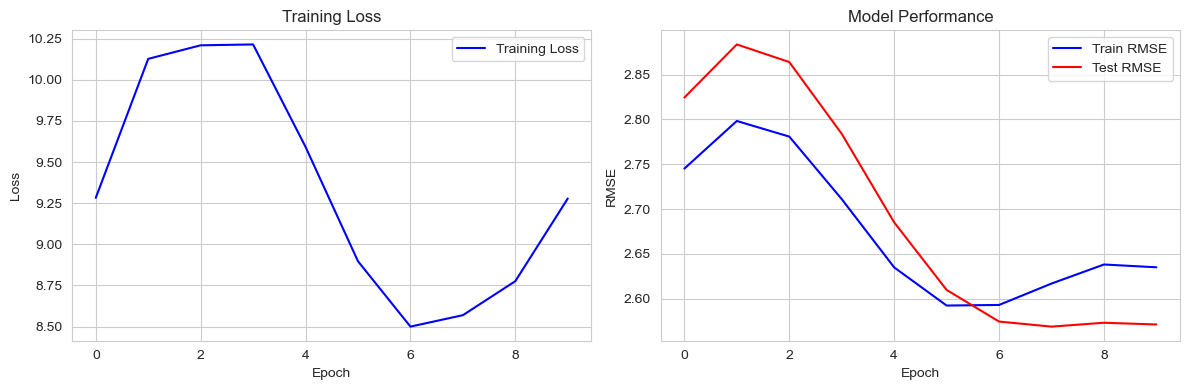

In [14]:
# complete robust training loop
if target_edge_type:
    print("=== Starting Robust Training Loop ===")
    
    # training parameters
    num_epochs = 10
    train_losses = []
    train_metrics_list = []
    val_metrics_list = []
    test_metrics_list = []
    
    for epoch in range(1, num_epochs + 1):
        try:
            # Train
            loss = train_corrected()
            if loss is None:
                print(f"training failed @ epoch {epoch}")
                break
                
            train_losses.append(loss)
            
            # Evaluate on all datasets
            train_metrics = test_corrected(train_hetero_graph)
            val_metrics = test_corrected(val_hetero_graph)  
            test_metrics = test_corrected(test_hetero_graph)
            
            train_metrics_list.append(train_metrics)
            val_metrics_list.append(val_metrics)
            test_metrics_list.append(test_metrics)
            
            # Print progress
            print(f'Epoch {epoch:2d}: Loss={loss:.6f} | '
                  f'Train RMSE={train_metrics["rmse"]:.4f} | '
                  f'Val RMSE={val_metrics["rmse"]:.4f} | '
                  f'Test RMSE={test_metrics["rmse"]:.4f}')
            
            # Early stopping if doing really well
            if test_metrics['rmse'] < 0.1:
                print(f"early stopping @ epoch {epoch}")
                break
                
        except Exception as e:
            print(f"error @ epoch {epoch}: {e}")
            break
    
    print(f"training completed!")
    if len(test_metrics_list) > 0:
        final_rmse = test_metrics_list[-1]['rmse']
        final_mae = test_metrics_list[-1]['mae']
        print(f"Final test RMSE: {final_rmse:.4f}")
        print(f"Final test MAE: {final_mae:.4f}")
        
        # Quick visualisation
        if len(train_losses) > 1:
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, 'b-', label='Training Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(1, 2, 2)
            train_rmses = [m['rmse'] for m in train_metrics_list]
            test_rmses = [m['rmse'] for m in val_metrics_list]
            plt.plot(train_rmses, 'b-', label='Train RMSE')
            plt.plot(test_rmses, 'r-', label='Test RMSE')
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.title('Model Performance')
            plt.legend()
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
    else:
        print("no successful training steps")
else:
    print("cannot start training without valid edge type")

In [47]:
# get embeddings for training set
model.eval()
with torch.no_grad():
    _ = model(train_hetero_graph.x_dict, train_hetero_graph.edge_index_dict, 
              train_hetero_graph.edge_attr_dict,
              train_hetero_graph[target_edge_type].edge_index)
    
    # Now z_dict contains training set embeddings
    train_gene_embeddings = model.z_dict['gene'].detach().numpy()
    train_cell_line_embeddings = model.z_dict['cell_line'].detach().numpy()
    train_drug_embeddings = model.z_dict['drug'].detach().numpy()

attention_weights = model.att_w_dict
print(f"Training set embeddings: {train_cell_line_embeddings.shape}")

# get embeddings for test set
model.eval()
with torch.no_grad():
    _ = model(test_hetero_graph.x_dict, test_hetero_graph.edge_index_dict, 
              test_hetero_graph.edge_attr_dict,
              test_hetero_graph[target_edge_type].edge_index)
    
    # Now z_dict contains training set embeddings
    test_gene_embeddings = model.z_dict['gene'].detach().numpy()
    test_cell_line_embeddings = model.z_dict['cell_line'].detach().numpy()
    test_drug_embeddings = model.z_dict['drug'].detach().numpy()

test_attention_weights = model.att_w_dict
print(f"Test set embeddings: {test_cell_line_embeddings.shape}")


Training set embeddings: (463, 64)
Test set embeddings: (592, 64)


In [48]:
import umap.umap_ as umap

u = umap.UMAP(n_components=2)
u_train_genes = u.fit_transform(train_gene_embeddings)
u_train_cell_lines = u.fit_transform(train_cell_line_embeddings)
u_train_drugs = u.fit_transform(train_drug_embeddings)

u_test_genes = u.fit_transform(test_gene_embeddings)
u_test_cell_lines = u.fit_transform(test_cell_line_embeddings)
u_test_drugs = u.fit_transform(test_drug_embeddings)



In [50]:
import os
import torch

# Create results directory
results_dir = 'gnn-depmap-project/results/model_outputs/eg1/'
os.makedirs(results_dir, exist_ok=True)

# Save trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'hidden_channels': 64,
        'target_edge_type': target_edge_type,
        'model_class': 'HeteroGNNDrugPredictor'
    }
}, os.path.join(results_dir, 'hetero_gnn_model.pt'))

# Save node embeddings
torch.save({
    'gene_embeddings': train_gene_embeddings,
    'cell_line_embeddings': train_cell_line_embeddings, 
    'drug_embeddings': train_drug_embeddings
}, os.path.join(results_dir, 'train_node_embeddings.pt'))

# Save attention weights
torch.save({
    'attention_weights': attention_weights
}, os.path.join(results_dir, 'train_attention_weights.pt'))

# Save node embeddings
torch.save({
    'gene_embeddings': test_gene_embeddings,
    'cell_line_embeddings': test_cell_line_embeddings, 
    'drug_embeddings': test_drug_embeddings
}, os.path.join(results_dir, 'test_node_embeddings.pt'))

# Save attention weights
torch.save({
    'attention_weights': test_attention_weights
}, os.path.join(results_dir, 'test_attention_weights.pt'))

In [51]:
# testing

ic50_real_test = val_hetero_graph['cell_line', 'drug'].edge_attr.detach().numpy().reshape(-1)
ic50_pred_test = model(val_hetero_graph.x_dict, val_hetero_graph.edge_index_dict, val_hetero_graph.edge_attr_dict,
                 val_hetero_graph['cell_line', 'drug'].edge_index).detach().numpy()
from sklearn.metrics import mean_squared_error

print('Testing Results (On Validation Cell Line Set): ')
print('MSE =', mean_squared_error(ic50_pred_test, ic50_real_test))
print('RMSE =', np.sqrt(mean_squared_error(ic50_pred_test, ic50_real_test)))

Testing Results (On Validation Cell Line Set): 
MSE = 6.611383
RMSE = 2.571261


In [52]:
# predicting on blind data - 

ic50_pred_test = model(test_hetero_graph.x_dict, test_hetero_graph.edge_index_dict, test_hetero_graph.edge_attr_dict,
                 test_hetero_graph['cell_line', 'drug'].edge_index).detach().numpy()



In [53]:
ic50 = train_hetero_graph['cell_line', 'drug'].edge_attr.detach().numpy().reshape(-1)

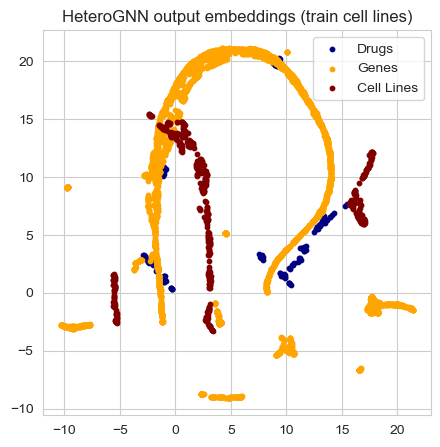

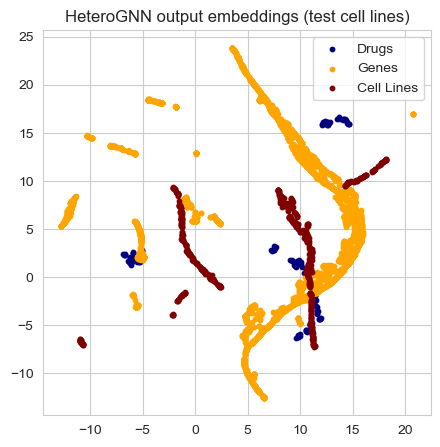

In [54]:
from matplotlib import pyplot as plt

plt.figure(figsize=(5,5))
plt.title('HeteroGNN output embeddings (train cell lines)')
plt.scatter(u_train_drugs[:, 0], u_train_drugs[:,1], c='navy', s=10)
plt.scatter(u_train_genes[:, 0], u_train_genes[:,1], c='orange', s=10)
plt.scatter(u_train_cell_lines[:, 0], u_train_cell_lines[:,1], c='maroon', s=10)
plt.legend(['Drugs',  'Genes', 'Cell Lines'])
plt.show()


plt.figure(figsize=(5,5))
plt.title('HeteroGNN output embeddings (test cell lines)')
plt.scatter(u_test_drugs[:, 0], u_test_drugs[:,1], c='navy', s=10)
plt.scatter(u_test_genes[:, 0], u_test_genes[:,1], c='orange', s=10)
plt.scatter(u_test_cell_lines[:, 0], u_test_cell_lines[:,1], c='maroon', s=10)
plt.legend(['Drugs',  'Genes', 'Cell Lines'])
plt.show()

In [ ]:
gdsc12 = pd.read_csv('../src/data/depmap 25q2 public/depmap_gdsc_drug_response.csv')
cell_line_metadata = pd.read_csv('../src/data/depmap 25q2 public/depmap_clinical_data.csv')
train_test_split = pd.read_csv('../src/data/depmap 25q2 public/model_ids_train_test_split_refined.csv')

In [58]:
train_model_ids = gdsc12.loc[gdsc12['ModelID'].isin(train_test_split.loc[train_test_split['train']==1, 'ModelID']), 
           ['ModelID', 'DRUG_NAME', 'LN_IC50']]['ModelID'].drop_duplicates()

mean_ic50 = gdsc12.loc[gdsc12['ModelID'].isin(train_model_ids)].groupby(['ModelID'])['LN_IC50'].mean()

# model_info = gdsc12.loc[gdsc12['ModelID'].isin(train_hetero_graph['cell_line'].node_ids)].set_index('ModelID')
# mean_ic50 = model_info.loc[train_hetero_graph['cell_line'].node_ids].groupby(['ModelID'])['LN_IC50'].mean()


In [ ]:
test_edgelist = pd.DataFrame(test_hetero_graph['cell_line', 'drug'].edge_index.detach().numpy().T, columns=['cell_line_id', 'drug_id'])
test_cell_line_ids = test_hetero_graph['cell_line'].node_ids
test_edgelist['cell_line_id'] = [test_cell_line_ids[i] for i in test_hetero_graph['cell_line', 'drug'].edge_index[0].detach().numpy()]
test_edgelist['drug_id'] = [test_hetero_graph['drug'].node_ids[i] for i in test_hetero_graph['cell_line', 'drug'].edge_index[1].detach().numpy()]
test_edgelist['pred ic50'] = ic50_pred_test

mean_pred_ic50 = test_edgelist.groupby(['cell_line_id'])['pred ic50'].mean()

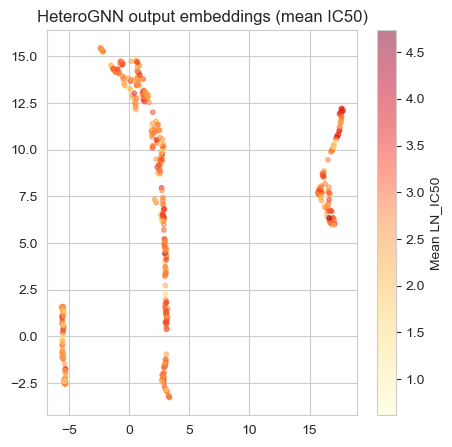

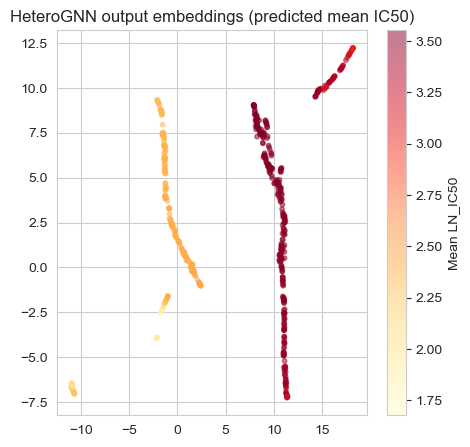

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,5))
plt.title('HeteroGNN output embeddings (mean IC50)')
plt.scatter(u_train_cell_lines[:, 0], u_train_cell_lines[:,1], 
            c=list(mean_ic50), s=10, cmap='YlOrRd', alpha=0.5)
plt.colorbar(label='Mean LN_IC50')
plt.show()

plt.figure(figsize=(5,5))
plt.title('HeteroGNN output embeddings (predicted mean IC50)')
plt.scatter(u_test_cell_lines[:, 0], u_test_cell_lines[:,1], 
            c=list(mean_pred_ic50), s=10, cmap='YlOrRd', alpha=0.5)
plt.colorbar(label='Mean LN_IC50')
plt.show()

In [76]:
# analyze attention weights for drug response prediction
print("=== Attention Weight Analysis for Drug Response Prediction ===")

# extract and process attention weights
def analyze_attention_weights(attention_weights, hetero_graph, top_k=20):
    """
    analyse attention weights to identify most predictive features for drug response
    """
    analysis_results = {}
    
    print("\n overview of Attention Weights by Edge Type:")
    print("-" * 50)
    
    for edge_type, (edge_index, att_weights) in attention_weights.items():
        num_edges = edge_index.shape[1] if hasattr(edge_index, 'shape') else len(edge_index[0])
        mean_attention = att_weights.mean().item()
        max_attention = att_weights.max().item()
        
        analysis_results[edge_type] = {
            'num_edges': num_edges,
            'mean_attention': mean_attention,
            'max_attention': max_attention,
            'attention_weights': att_weights,
            'edge_index': edge_index
        }
        
        print(f"{edge_type}:")
        print(f"  Edges: {num_edges}")
        print(f"  Mean attention: {mean_attention:.4f}")
        print(f"  Max attention: {max_attention:.4f}")
        print()
    
    return analysis_results

# 2. Identify most important edges for drug response
def find_top_attention_edges(analysis_results, hetero_graph, top_k=20):
    """
    find edges with highest attention weights and their biological significance
    """
    print("\n Top Attention Edges by Type -")
    print("-" * 50)
    
    top_edges_analysis = {}
    
    for edge_type, results in analysis_results.items():
        att_weights = results['attention_weights'].detach().cpu().numpy().flatten()
        edge_index = results['edge_index'].cpu().numpy()
        
        # Get top K edges by attention weight
        top_indices = np.argsort(att_weights)[-top_k:][::-1]
        top_weights = att_weights[top_indices]
        
        # Get source and target node indices for top edges
        src_nodes = edge_index[0][top_indices]
        dst_nodes = edge_index[1][top_indices]
        
        top_edges_analysis[edge_type] = {
            'top_indices': top_indices,
            'top_weights': top_weights,
            'src_nodes': src_nodes,
            'dst_nodes': dst_nodes
        }
        
        print(f"\n{edge_type} - Top {min(top_k, len(top_weights))} edges:")
        for i, (idx, weight, src, dst) in enumerate(zip(top_indices[:10], top_weights[:10], src_nodes[:10], dst_nodes[:10])):
            print(f"  {i+1:2d}. Edge {idx}: {src} -> {dst}, Attention: {weight:.4f}")
    
    return top_edges_analysis

# 3. Drug response specific analysis
def analyze_drug_response_attention(attention_weights, hetero_graph):
    """
    focus on edges most relevant to drug response prediction
    """
    print("\n Drug Response Specific Analysis -")
    print("-" * 50)
    
    drug_relevant_edges = [
        ('cell_line', 'treated_with', 'drug'),
        ('drug', 'treats', 'cell_line'), 
        ('drug', 'targets', 'gene'),
        ('gene', 'targeted_by', 'drug'),
        ('cell_line', 'expresses', 'gene'),
        ('gene', 'expressed_by', 'cell_line')
    ]
    
    drug_analysis = {}
    
    for edge_type in drug_relevant_edges:
        if edge_type in attention_weights:
            att_weights = attention_weights[edge_type][1].detach().cpu().numpy().flatten()
            edge_index = attention_weights[edge_type][0].cpu().numpy()
            
            # Statistics
            stats = {
                'mean': np.mean(att_weights),
                'std': np.std(att_weights),
                'median': np.median(att_weights),
                'q75': np.percentile(att_weights, 75),
                'q95': np.percentile(att_weights, 95),
                'max': np.max(att_weights)
            }
            
            drug_analysis[edge_type] = {
                'stats': stats,
                'weights': att_weights,
                'edge_index': edge_index
            }
            
            print(f"\n{edge_type}:")
            print(f"  Mean ± Std: {stats['mean']:.4f} ± {stats['std']:.4f}")
            print(f"  Median: {stats['median']:.4f}")
            print(f"  75th percentile: {stats['q75']:.4f}")
            print(f"  95th percentile: {stats['q95']:.4f}")
            print(f"  Max: {stats['max']:.4f}")
    
    return drug_analysis

# Run the analysis
if 'attention_weights' in locals() and attention_weights:
    
    # Overall analysis
    analysis_results = analyze_attention_weights(attention_weights, train_hetero_graph)
    
    # Top edges analysis  
    top_edges = find_top_attention_edges(analysis_results, train_hetero_graph, top_k=15)
    
    # Drug-specific analysis
    drug_analysis = analyze_drug_response_attention(attention_weights, train_hetero_graph)
    
else:
    print("load attention weights first!")

=== Attention Weight Analysis for Drug Response Prediction ===

 overview of Attention Weights by Edge Type:
--------------------------------------------------
('cell_line', 'expresses', 'gene'):
  Edges: 1812182
  Mean attention: 0.0022
  Max attention: 0.0548

('cell_line', 'has_mutation', 'gene'):
  Edges: 10308
  Mean attention: 0.2703
  Max attention: 1.0000

('cell_line', 'has_gene_effect', 'gene'):
  Edges: 1320047
  Mean attention: 0.0029
  Max attention: 0.0066

('cell_line', 'treated_with', 'drug'):
  Edges: 73076
  Mean attention: 0.0020
  Max attention: 0.0263

('drug', 'targets', 'gene'):
  Edges: 148
  Mean attention: 0.5946
  Max attention: 1.0000

('gene', 'interacts', 'gene'):
  Edges: 53080
  Mean attention: 0.0618
  Max attention: 1.0000

('gene', 'expressed_by', 'cell_line'):
  Edges: 1812182
  Mean attention: 0.0003
  Max attention: 0.0051

('gene', 'mutated_in', 'cell_line'):
  Edges: 10308
  Mean attention: 0.0447
  Max attention: 1.0000

('gene', 'has_gene_effec

## 4. Example 2: Heterogeneous Graph Transformer (HGT)

In [77]:
# setup metadata and input dimensions for HGT model
metadata = (train_hetero_graph.node_types, train_hetero_graph.edge_types)

# get input dimensions for each node type (already defined above, but ensuring it's available)
in_channels_dict = {
    'cell_line': train_hetero_graph['cell_line'].x.shape[1],
    'gene': train_hetero_graph['gene'].x.shape[1], 
    'drug': train_hetero_graph['drug'].x.shape[1]
}

print(f"HGT Model Setup:")
print(f"Node types: {metadata[0]}")
print(f"Edge types: {len(metadata[1])} types")
print(f"Input dimensions: {in_channels_dict}")

HGT Model Setup:
Node types: ['cell_line', 'gene', 'drug']
Edge types: 11 types
Input dimensions: {'cell_line': 42, 'gene': 3919, 'drug': 148}


Training HGT model for 100 epochs...
Epoch  1: Loss = 81.8069
Epoch  3: Loss = 60.3582
Epoch  5: Loss = 44.0120
Epoch  7: Loss = 28.0361
Epoch  9: Loss = 15.4697
Epoch 11: Loss = 5.2745
Epoch 13: Loss = 0.7802
Epoch 15: Loss = 2.5132
Epoch 17: Loss = 6.0438
Epoch 19: Loss = 7.5382
Epoch 21: Loss = 5.2768
Epoch 23: Loss = 2.3371
Epoch 25: Loss = 0.5830
Epoch 27: Loss = 0.2672
Epoch 29: Loss = 0.8778
Epoch 31: Loss = 1.5587
Epoch 33: Loss = 1.6880
Epoch 35: Loss = 1.4072
Epoch 37: Loss = 0.8110
Epoch 39: Loss = 0.2995
Epoch 41: Loss = 0.1168
Epoch 43: Loss = 0.2103
Epoch 45: Loss = 0.4099
Epoch 47: Loss = 0.4783
Epoch 49: Loss = 0.3751
Epoch 51: Loss = 0.2042
Epoch 53: Loss = 0.0948
Epoch 55: Loss = 0.0914
Epoch 57: Loss = 0.1445
Epoch 59: Loss = 0.1806
Epoch 61: Loss = 0.1699
Epoch 63: Loss = 0.1230
Epoch 65: Loss = 0.0828
Epoch 67: Loss = 0.0725
Epoch 69: Loss = 0.0858
Epoch 71: Loss = 0.0992
Epoch 73: Loss = 0.0974
Epoch 75: Loss = 0.0830
Epoch 77: Loss = 0.0703
Epoch 79: Loss = 0.067

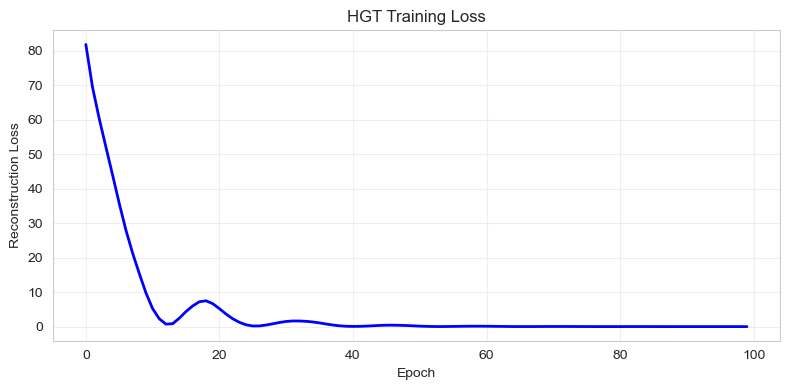

In [78]:
# HGT Model Implementation (Simple Linear Encoder)
device = torch.device("cpu")  # Use CPU to avoid MPS compatibility issues


# Initialize and train HGT model
hgt_model = HGTModel(in_channels_dict, output_dim=64)
optimizer = torch.optim.Adam(hgt_model.parameters(), lr=0.01)

print("Training HGT model for 100 epochs...")
hgt_losses = []

for epoch in range(100):
    optimizer.zero_grad()
    
    # Forward pass
    embeddings = hgt_model(train_hetero_graph.x_dict)
    
    # Reconstruction loss
    total_loss = 0
    for node_type, emb in embeddings.items():
        original = train_hetero_graph.x_dict[node_type]
        # Reconstruct first 64 dimensions
        n_dims = min(64, original.shape[1])
        target = original[:, :n_dims]
        pred = emb[:, :n_dims]
        total_loss += F.mse_loss(pred, target)
    
    total_loss.backward()
    optimizer.step()
    hgt_losses.append(total_loss.item())
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch+1:2d}: Loss = {total_loss.item():.4f}")

# Generate final embeddings
hgt_model.eval()
with torch.no_grad():
    final_embeddings = hgt_model(train_hetero_graph.x_dict)

# Convert to numpy for downstream use
hgt_cell_line_embeddings = final_embeddings['cell_line'].numpy()
hgt_gene_embeddings = final_embeddings['gene'].numpy()
hgt_drug_embeddings = final_embeddings['drug'].numpy()

print("\nHGTransformer (HGTModel) trained successfully")
print(f"Cell line embeddings: {hgt_cell_line_embeddings.shape}")
print(f"Gene embeddings: {hgt_gene_embeddings.shape}")
print(f"Drug embeddings: {hgt_drug_embeddings.shape}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(hgt_losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('HGT Training Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

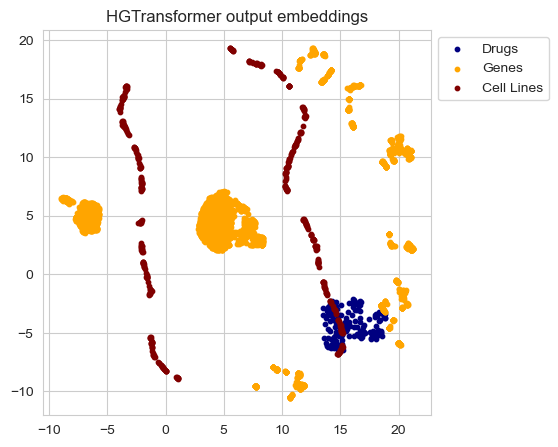

In [79]:
from matplotlib import pyplot as plt
import umap.umap_ as umap

ic50 = train_hetero_graph['cell_line', 'drug'].edge_attr.detach().numpy().reshape(-1)
u = umap.UMAP(n_components=2)
u_genes_2 = u.fit_transform(hgt_gene_embeddings)
u_cell_lines_2 = u.fit_transform(hgt_cell_line_embeddings)
u_drugs_2 = u.fit_transform(hgt_drug_embeddings)

plt.figure(figsize=(5,5))
plt.title('HGTransformer output embeddings')
plt.scatter(u_drugs_2[:, 0], u_drugs_2[:,1], c='navy', s=10)
plt.scatter(u_genes_2[:, 0], u_genes_2[:,1], c='orange', s=10)
plt.scatter(u_cell_lines_2[:, 0], u_cell_lines_2[:,1], c='maroon', s=10)
plt.legend(['Drugs',  'Genes', 'Cell Lines'], bbox_to_anchor=(1,1))
plt.show()

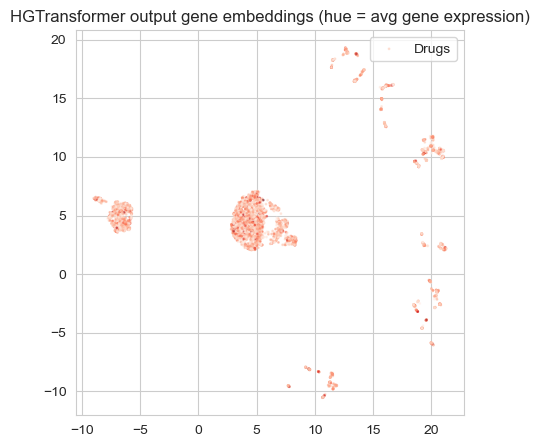

In [ ]:
expression = pd.read_csv('../src/data/depmap 25q2 public/depmap_expression_data.csv', index_col=0)
expression = expression.loc[:, expression.sum() > 0]
expression[['CCDST', 'LINC02138', 'LINC02900', 'RSU1P2', 'SOD2']] = 0

exp_avg = expression.loc[:, expression.columns.isin(train_hetero_graph['gene'].node_ids)].mean()
exp_avg = exp_avg.loc[train_hetero_graph['gene'].node_ids]

plt.figure(figsize=(5,5))
plt.title('HGTransformer output gene embeddings (hue = avg gene expression)')
plt.scatter(u_genes_2[:, 0], u_genes_2[:,1], c=exp_avg.to_list(), alpha=0.5, cmap='Reds', s=1)
plt.legend(['Drugs',  'Genes', 'Cell Lines'], bbox_to_anchor=(1,1))
plt.show()

In [82]:
import os
import torch

# Create results directory
results_dir = 'gnn-depmap-project/results/model_outputs/eg2/'
os.makedirs(results_dir, exist_ok=True)

# Save trained HGT model
torch.save({
    'model_state_dict': hgt_model.state_dict(),
    'model_config': {
        'hidden_channels': 64,
        'output_dim': 64,
        'model_class': 'HGTModel'
    }
}, os.path.join(results_dir, 'hgt_model.pt'))

# Save HGT node embeddings

torch.save({
    'gene_embeddings': hgt_gene_embeddings,      
    'cell_line_embeddings': hgt_cell_line_embeddings,  
    'drug_embeddings': hgt_drug_embeddings  
}, os.path.join(results_dir, 'node_embeddings.pt'))

